
# NEWS category detector

This dataset contains around 200k news headlines from the year 2012 to 2018 obtained from HuffPost. The model trained on this dataset could be used to identify tags for untracked news articles or to identify the type of language used in different news articles.

https://www.kaggle.com/rmisra/news-category-dataset

In [2]:
import json
import pandas as pd
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
import string
import pickle as pk

from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.utils import np_utils

## Data pre-processing
### Importing data and creating a parsed out database

In [85]:
df = pd.read_json('News_Category_Dataset_v2.json', lines=True)
df.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [259]:
# Check size of each category
df.groupby('category').size()

category
ARTS               1509
ARTS & CULTURE     1339
BLACK VOICES       4528
BUSINESS           5937
COLLEGE            1144
COMEDY             5175
CRIME              3405
CULTURE & ARTS     1030
DIVORCE            3426
EDUCATION          1004
ENTERTAINMENT     16058
ENVIRONMENT        1323
FIFTY              1401
FOOD & DRINK       6226
GOOD NEWS          1398
GREEN              2622
HEALTHY LIVING     6694
HOME & LIVING      4195
IMPACT             3459
LATINO VOICES      1129
MEDIA              2815
MONEY              1707
PARENTING          8677
PARENTS            3955
POLITICS          32739
QUEER VOICES       6314
RELIGION           2556
SCIENCE            2178
SPORTS             4884
STYLE              2254
STYLE & BEAUTY     9649
TASTE              2096
TECH               2082
THE WORLDPOST      3664
TRAVEL             9887
WEDDINGS           3651
WEIRD NEWS         2670
WELLNESS          17827
WOMEN              3490
WORLD NEWS         2177
WORLDPOST          2579
dtype: 

In [260]:
# Merging categories
df.category = df.category.map(lambda x: "ARTS & CULTURE" if x == "ARTS" else x)
df.category = df.category.map(lambda x: "ARTS & CULTURE" if x == "CULTURE & ARTS" else x)
df.category = df.category.map(lambda x: "STYLE & BEAUTY" if x == "STYLE" else x)
df.category = df.category.map(lambda x: "WORLDPOST" if x == "THE WORLDPOST" else x)
df.category = df.category.map(lambda x: "ENVIRONMENT" if x == "GREEN" else x)
df.category = df.category.map(lambda x: "PARENTS" if x == "PARENTING" else x)

# Remove categories
df = df[df['category'] != 'FIFTY']

In [261]:
# Re-check size
df.groupby('category').size()

category
ARTS & CULTURE     3878
BLACK VOICES       4528
BUSINESS           5937
COLLEGE            1144
COMEDY             5175
CRIME              3405
DIVORCE            3426
EDUCATION          1004
ENTERTAINMENT     16058
ENVIRONMENT        3945
FOOD & DRINK       6226
GOOD NEWS          1398
HEALTHY LIVING     6694
HOME & LIVING      4195
IMPACT             3459
LATINO VOICES      1129
MEDIA              2815
MONEY              1707
PARENTS           12632
POLITICS          32739
QUEER VOICES       6314
RELIGION           2556
SCIENCE            2178
SPORTS             4884
STYLE & BEAUTY    11903
TASTE              2096
TECH               2082
TRAVEL             9887
WEDDINGS           3651
WEIRD NEWS         2670
WELLNESS          17827
WOMEN              3490
WORLD NEWS         2177
WORLDPOST          6243
dtype: int64

In [262]:
# merge headline and description
df['text'] = df['headline']+' '+df['short_description']
df.drop(['short_description','headline'],axis=1,inplace=True)

In [263]:
df

,category,authors,link,date,text
0,CRIME,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...
1,ENTERTAINMENT,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...
2,ENTERTAINMENT,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,2018-05-26,Hugh Grant Marries For The First Time At Age 5...
3,ENTERTAINMENT,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...
4,ENTERTAINMENT,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...
...,...,...,...,...,...
200848,TECH,"Reuters, Reuters",https://www.huffingtonpost.com/entry/rim-ceo-t...,2012-01-28,RIM CEO Thorsten Heins' 'Significant' Plans Fo...
200849,SPORTS,,https://www.huffingtonpost.com/entry/maria-sha...,2012-01-28,Maria Sharapova Stunned By Victoria Azarenka I...
200850,SPORTS,,https://www.huffingtonpost.com/entry/super-bow...,2012-01-28,"Giants Over Patriots, Jets Over Colts Among M..."
200851,SPORTS,,https://www.huffingtonpost.com/entry/aldon-smi...,2012-01-28,Aldon Smith Arrested: 49ers Linebacker Busted ...


In [264]:
# Load english stopwords
import nltk
nltk.download('stopwords')
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\laure\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
### TO BE COPIED IN DATA PREPARATION SCRIPT ###

# Parsing text + cleaning + stemm
def parse_out_text(all_text):
    # clean punctuation, make lower case and remove stopwords
    text_string = all_text.translate(str.maketrans("", "", string.punctuation)).split(" ")
    text_string = [word.lower() for word in text_string if word.lower() not in stopwords.words('english')]
    # Stemm text
    stemmer = SnowballStemmer("english")
    stemmed = [stemmer.stem(word) for  word in text_string]
    words = " ".join(stemmed) 
    return words

In [266]:
# Text example
text_test = df['text'].iloc[42]
text_test

'2 People Injured In Indiana School Shooting A male student, believed to be the suspect, has been detained, according to police.'

In [267]:
# Parsed text example
parse_out_text(text_test)

'2 peopl injur indiana school shoot male student believ suspect detain accord polic'

In [275]:
# Resetting index (num rows = id)
df = df.reset_index()

In [277]:
# Create a column with parsed-out text
from ipywidgets import IntProgress
from IPython.display import display
import time

def create_parsed_df(extract_df):

    pd.options.mode.chained_assignment = None  # default='warn'

    extract_df['parsed_text'] = 'NaN'
    extract_df.drop(['authors','link','date'],axis=1, inplace=True)

    max_count = extract_df.shape[0]

    f = IntProgress(min=0, max=max_count) # instantiate the bar
    display(f) # display the bar

    for i in range(len(extract_df['text'])):
        f.value += 1
        item = parse_out_text(extract_df['text'].iloc[i])
        extract_df['parsed_text'][i] = item

    extract_df.to_csv('data.csv')
    
    return extract_df

In [278]:
## TAKES SOME TIME AND ERASES data.csv -> DON'T TOUCH !
create_parsed_df(df)

IntProgress(value=0, max=199452)

,index,category,text,parsed_text
0,0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,2 mass shoot texa last week 1 tv left husband ...
1,1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,smith join diplo nicki jam 2018 world cup offi...
2,2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 5...,hugh grant marri first time age 57 actor longt...
3,3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,jim carrey blast castrato adam schiff democrat...
4,4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,julianna marguli use donald trump poop bag pic...
...,...,...,...,...
199447,200848,TECH,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,rim ceo thorsten hein signific plan blackberri...
199448,200849,SPORTS,Maria Sharapova Stunned By Victoria Azarenka I...,maria sharapova stun victoria azarenka austral...
199449,200850,SPORTS,"Giants Over Patriots, Jets Over Colts Among M...",giant patriot jet colt among improb super bow...
199450,200851,SPORTS,Aldon Smith Arrested: 49ers Linebacker Busted ...,aldon smith arrest 49er lineback bust dui corr...


## Transform data to numerical
### Reduce dataset size

In [4]:
# Full df
df_full = pd.read_csv('data.csv')[['parsed_text','category']]

In [5]:
# Reduce number of lines (123 GiB needed else...)
def reduce_df(df, fraction):
    df_reduced = pd.DataFrame(columns=['parsed_text','category'])
    for cat in set(df_full['category']):
        # Randomly sample x% of your dataframe
        df_reduced = df_reduced.append(df[df['category'] == cat].sample(frac=fraction))
    return df_reduced.reset_index()

df_parsed = reduce_df(df_full,0.1)

In [6]:
df_parsed.drop('index',axis=1, inplace=True)
df_parsed.shape

(19947, 2)

In [7]:
# Check number of points per category
df_parsed.groupby('category').size()

category
ARTS & CULTURE     388
BLACK VOICES       453
BUSINESS           594
COLLEGE            114
COMEDY             518
CRIME              340
DIVORCE            343
EDUCATION          100
ENTERTAINMENT     1606
ENVIRONMENT        394
FOOD & DRINK       623
GOOD NEWS          140
HEALTHY LIVING     669
HOME & LIVING      420
IMPACT             346
LATINO VOICES      113
MEDIA              282
MONEY              171
PARENTS           1263
POLITICS          3274
QUEER VOICES       631
RELIGION           256
SCIENCE            218
SPORTS             488
STYLE & BEAUTY    1190
TASTE              210
TECH               208
TRAVEL             989
WEDDINGS           365
WEIRD NEWS         267
WELLNESS          1783
WOMEN              349
WORLD NEWS         218
WORLDPOST          624
dtype: int64

In [8]:
# Check for NaN and drop them
print(df_parsed.isna().sum())
df_parsed = df_parsed.dropna()

parsed_text    0
category       0
dtype: int64


In [9]:
df_parsed

,parsed_text,category
0,usain boltandr de grass bromanc got meme obvio...,SPORTS
1,ami schumer put game face bud light super bowl...,SPORTS
2,mlb pitcher punch face realli hard blow game a...,SPORTS
3,report ray rice told nfl commish june hit wife,SPORTS
4,inconspicu man shaquill oneal lyft driver day ...,SPORTS
...,...,...
19942,togo burger seulbi kim rethink fast food packa...,FOOD & DRINK
19943,pickleback one editor fell love pickl juic sho...,FOOD & DRINK
19944,recip day chile relleno top tomatoandavocado s...,FOOD & DRINK
19945,hostess gift holiday flurri social engag invit...,FOOD & DRINK


#### Check for most common words for a category

In [10]:
# Loop over all the words in all the texts and increment the counts in the appropriate counter objects
def count_most_common(cat):
    count_word = Counter()
    df_cat = df_parsed[df_parsed['category'] == cat]
    for article in df_cat['parsed_text']:
        for word in article.split(" "):
            count_word[word] += 1
    return count_word.most_common(10)

In [11]:
count_most_common('TECH')

[('video', 32),
 ('new', 31),
 ('googl', 31),
 ('', 30),
 ('appl', 28),
 ('week', 28),
 ('look', 24),
 ('facebook', 23),
 ('youtub', 23),
 ('compani', 19)]

### Extract features and labels

In [12]:
# List of features and labels
parsed_text = list(df_parsed['parsed_text'])
categories = list(df_parsed['category'])
set(categories)

{'ARTS & CULTURE',
 'BLACK VOICES',
 'BUSINESS',
 'COLLEGE',
 'COMEDY',
 'CRIME',
 'DIVORCE',
 'EDUCATION',
 'ENTERTAINMENT',
 'ENVIRONMENT',
 'FOOD & DRINK',
 'GOOD NEWS',
 'HEALTHY LIVING',
 'HOME & LIVING',
 'IMPACT',
 'LATINO VOICES',
 'MEDIA',
 'MONEY',
 'PARENTS',
 'POLITICS',
 'QUEER VOICES',
 'RELIGION',
 'SCIENCE',
 'SPORTS',
 'STYLE & BEAUTY',
 'TASTE',
 'TECH',
 'TRAVEL',
 'WEDDINGS',
 'WEIRD NEWS',
 'WELLNESS',
 'WOMEN',
 'WORLD NEWS',
 'WORLDPOST'}

#### Features

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(parsed_text)
X = X.toarray()

In [14]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [15]:
words = vectorizer.get_feature_names()
words[2000:2010]

['argentinian',
 'argento',
 'argo',
 'argonn',
 'argu',
 'arguabl',
 'argument',
 'ari',
 'aria',
 'ariad']

In [16]:
# dump classifier in a pickle file
with open("vectorizer.pkl", 'wb') as file:
    pk.dump(vectorizer, file)

In [17]:
print(X.shape)

(19947, 25936)


#### Labels

In [18]:
# Convert categrory words into integers
word_to_int = dict((c, i) for i, c in enumerate(set(df_full['category'])))
labels = [word_to_int[cat] for cat in categories]
# hot-encode the labels
y = np_utils.to_categorical(labels)
print(y.shape)

(19947, 34)


## Deep learning

In [19]:
# create train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=None)

In [20]:
X_train.shape

(15957, 25936)

In [21]:
# Building the model
model = Sequential()
model.add(Dense(256, activation='relu', input_dim = X_train.shape[1]))
model.add(Dropout(.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(.1))
model.add(Dense(y_train.shape[1], activation='softmax'))

# Compiling the model
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               6639872   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 34)                4386      
Total params: 6,677,154
Trainable params: 6,677,154
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Training the model
model.fit(X_train, y_train, epochs = 10,batch_size = 100, verbose = 1)
# Evaluation
score = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: ", score[1])


Epoch 1/10
15957/15957 [==============================] - 133s 8ms/step - loss: 2.5165 - accuracy: 0.3725
Epoch 2/10
15957/15957 [==============================] - 132s 8ms/step - loss: 1.1648 - accuracy: 0.6935
Epoch 3/10
15957/15957 [==============================] - 129s 8ms/step - loss: 0.4540 - accuracy: 0.8864
Epoch 4/10
15957/15957 [==============================] - 130s 8ms/step - loss: 0.1788 - accuracy: 0.9620
Epoch 5/10
15957/15957 [==============================] - 133s 8ms/step - loss: 0.0835 - accuracy: 0.9859
Epoch 6/10
15957/15957 [==============================] - 129s 8ms/step - loss: 0.0453 - accuracy: 0.9938
Epoch 7/10
15957/15957 [==============================] - 129s 8ms/step - loss: 0.0280 - accuracy: 0.9969
Epoch 8/10
15957/15957 [==============================] - 129s 8ms/step - loss: 0.0179 - accuracy: 0.9985
Epoch 9/10
15957/15957 [==============================] - 130s 8ms/step - loss: 0.0132 - accuracy: 0.9991
Epoch 10/10
15957/15957 [====================

In [23]:
from keras.models import load_model
model.save('News_classifier_model.h5')

In [24]:
# dump categories in a pickle file
with open("categ.pkl", 'wb') as file:
    pk.dump(list(set(categories)), file)

## Test model

In [25]:
# Load vectorizer
with open("vectorizer.pkl", 'rb') as fid:
    vectorizer_trained = pk.load(fid)

# Load model
trained_model = load_model('News_classifier_model.h5')

# Parsing text + cleaning + stemm
def parse_out_text(all_text):
    # clean punctuation, make lower case and remove stopwords
    text_string = all_text.translate(str.maketrans("", "", string.punctuation)).split(" ")
    text_string = [word.lower() for word in text_string if word.lower() not in stopwords.words('english')]
    # Stemm text
    stemmer = SnowballStemmer("english")
    stemmed = [stemmer.stem(word) for  word in text_string]
    words = " ".join(stemmed) 
    return words

In [39]:
text_to_predict = 'If you think you might be ready to fly again, we can help plan your trip'
text_to_predict = 'Google just created the most detailed image of a brain yet'
text_to_predict = 'The mysterious skeleton of a woman who died more than 4,000 years ago has been discovered in Germany.'
text_to_predict = 'The largest company sells its shares'

In [40]:
prepared_text = parse_out_text(text_to_predict)
feat_array = vectorizer_trained.transform([prepared_text]).toarray()
result = trained_model.predict(feat_array)[0]

df_result = pd.DataFrame({
    'Category':list(set(categories)),
    'Probability':result
}).sort_values('Probability',ascending=False).head(10)

df_result['Probability'].astype(float)
output = str(df_result['Category'].iloc[0])+': '+str(round(df_result['Probability'].iloc[0]*100,1))+'%'
print(output)

BUSINESS: 52.7%


<Figure size 720x720 with 0 Axes>

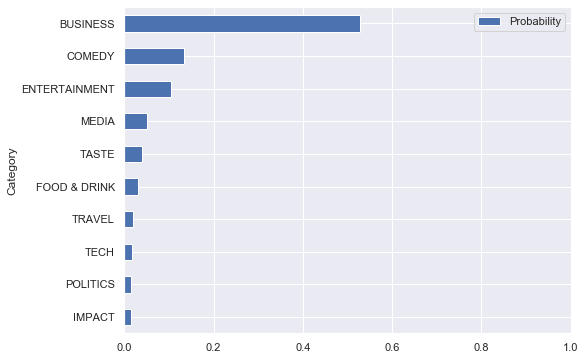

In [41]:
plt.figure(figsize=(10,10)) 
df_result.plot(kind='barh', x='Category',y='Probability',figsize=(8,6))
# Inverting y axis to have a top-down display
plt.gca().invert_yaxis()
plt.xlim(0,1);